In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [455]:
import numpy as np
import sys
import os
sys.path.append("../")
import utils.common
import seaborn as sns
import matplotlib.pyplot as plt
# from utils.common import get_trial_paths, get_trial_df, get_initial_state_df, get_prey_pos_df, display_prey_agent_pos, get_agent_pos_df, get_occluders_pos_df

In [507]:
human_base_path = '../../logs/exp_pong_single_ball/0'
trial_paths = get_trial_paths(human_base_path)
trial_df = get_trial_df(trial_paths)
initial_state_df = get_initial_state_df(trial_df)
prey_pos_df = get_prey_pos_df(trial_df)
agent_df = get_agent_pos_df(trial_df)[['trial_num', 'agent_pos']]
occluders_df = get_occluders_pos_df(trial_df)[['trial_num', 'occluders_pos']]
pos_df = prey_pos_df.merge(agent_df, on='trial_num').merge(occluders_df, on='trial_num')
prey_visible_df = utils.common.get_prey_visible(pos_df)[['trial_num', 'prey_visible']]
pos_df = pos_df.merge(prey_visible_df, on='trial_num')
condition_df = utils.common.get_condition_df(initial_state_df)[['prey_vel', 'prey_x', 'occluded', 'trial_num']]
error_df = utils.common.get_error_df(pos_df)
error_df = error_df.merge(condition_df, on='trial_num')
pos_df = pos_df.merge(condition_df, on='trial_num')
pos_df = utils.common.get_prey_visible_step_df(pos_df)

In [525]:
utils.common.get_trajectory_df(pos_df)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 69 and the array at index 1 has size 68

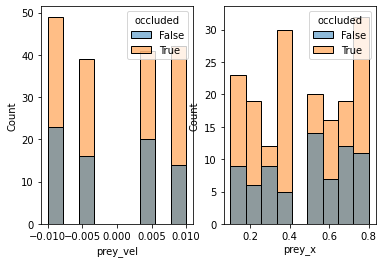

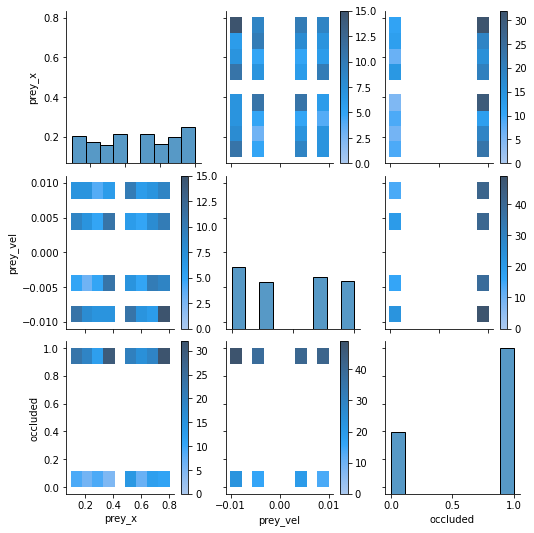

In [519]:
utils.common.display_condition_distr(condition_df)

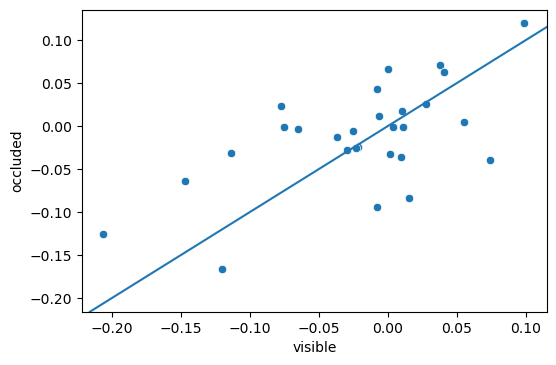

In [501]:
utils.common.display_condition_error(error_df)

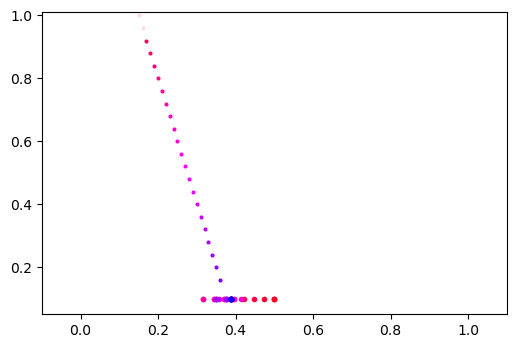

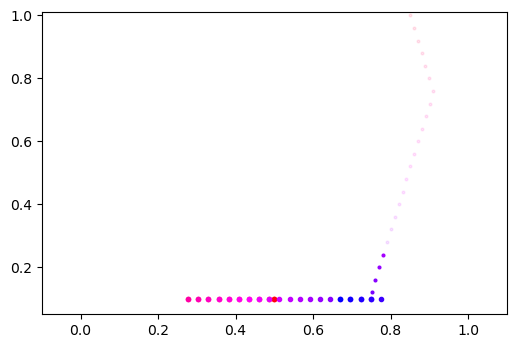

In [468]:
display_prey_agent_pos(pos_df.iloc[1:3])